In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

from rdkit import Chem
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

import umap
import umap.plot

tqdm.pandas()

mol_path = os.path.abspath(os.path.join(
    os.path.abspath(""), "..", # root directory
    "generated_molecules", # directory with experimental results
    "rerun_diffseeds", # run name
))

feature_order = {i: f for i, f in enumerate(['LUMO_eV', 'GAP_eV', 'Erel_eV', 'aIP_eV', 'aEA_eV'])}
feature_order

/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/umap/d

{0: 'LUMO_eV', 1: 'GAP_eV', 2: 'Erel_eV', 3: 'aIP_eV', 4: 'aEA_eV'}

In [2]:
# load dataset
df = pd.read_pickle("/data/stat-cadd/bras5033/guided_diffusion/GaUDI/data/datasets/COMPAS-1x_reduced.csv")
df["objective"] = 3*df["GAP_eV"] + df["aIP_eV"] - df["aEA_eV"]
df["objective"] = (df.objective  - df.objective.min()) / (df.objective.max() - df.objective.min())

# discard benzene
df = df[df["n_rings"] > 10]

In [3]:
split_map = {
        -1: "< 11 rings", 0: "training set", 1: "validation set", 2: "test_set",
    }

df["Data Split"] = df["cluster_split"].map(split_map) 

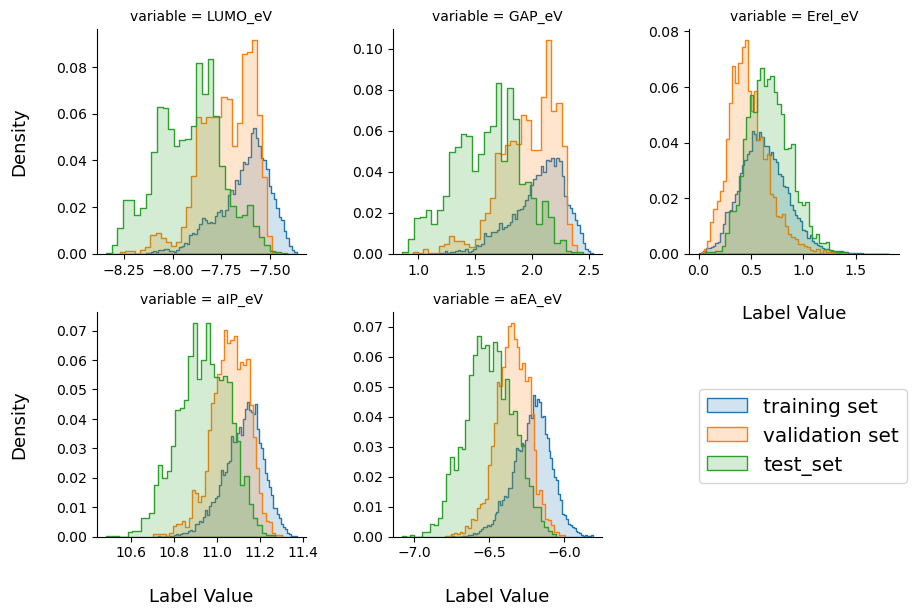

In [4]:
g = sns.FacetGrid(data=df[list(feature_order.values()) + ["Data Split"]].melt(
    id_vars=["Data Split"]), col="variable", sharex=False, sharey=False, col_wrap=3, hue="Data Split", col_order=list(feature_order.values()))
g.map_dataframe(sns.histplot, x="value", element="step", common_bins=False, common_norm=False, alpha=0.2, stat="probability")
g.add_legend()

g.set_axis_labels("Label Value", "Density", fontsize=13, labelpad=20)
sns.move_legend(g, "lower right", bbox_to_anchor=(.83, .25))
plt.legend(fontsize='x-large', title_fontsize='40', bbox_to_anchor=(2.5, 0.7))
g.legend.remove()

plt.savefig(f"materials_properties.pdf", bbox_inches="tight")

In [5]:
# load fingerprint similarities
dists = 1 - np.load("/data/stat-cadd/bras5033/guided_diffusion/GaUDI/data/datasets/COMPAS_tanimoto_count_sims.npy")
dists = dists[np.ix_(df.index.values, df.index.values)]

In [6]:
len(dists), len(df)

(25394, 25394)

In [7]:
mapper = umap.UMAP(n_neighbors=500, min_dist=0.1, metric="precomputed", random_state=42).fit(dists)

/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


/tmp/ipykernel_2187605/583218786.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple)


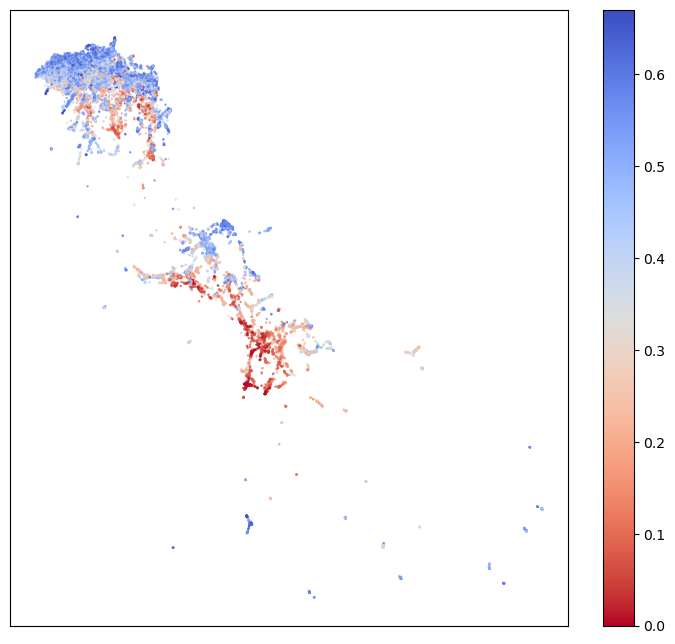

In [8]:
g = umap.plot.points(
    mapper, labels=df["objective"], alpha=0.5, color_key_cmap='coolwarm_r', background='white', show_legend=False,
    width=900, height=800
)

g.texts[0].remove()

divnorm = colors.TwoSlopeNorm(vmin=df["objective"].min(), vcenter=0.5, vmax=df["objective"].max())
scalarmappaple = cm.ScalarMappable(cmap=cm.coolwarm_r)
scalarmappaple.set_array(df["objective"])
plt.colorbar(scalarmappaple)

plt.savefig("materials_umap_just_labels.png", bbox_inches='tight')

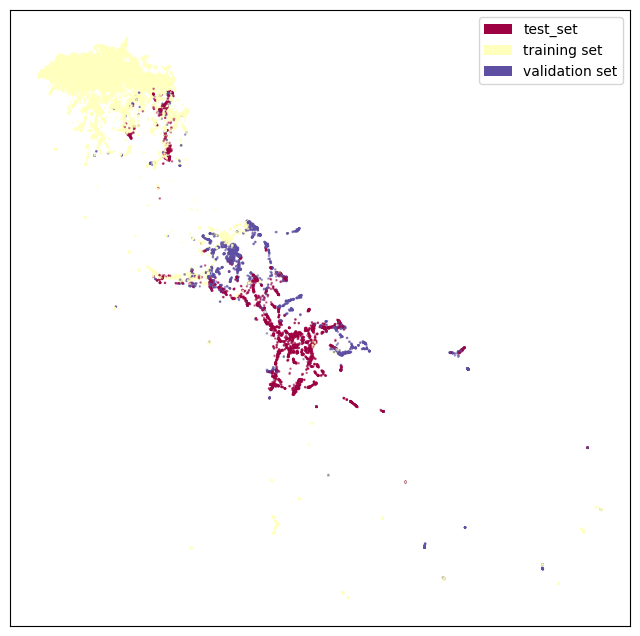

In [9]:
split_map = {
        -1: "< 11 rings", 0: "training set", 1: "validation set", 2: "test_set",
    }
g = umap.plot.points(
    mapper, labels=df["cluster_split"].map(split_map), alpha=0.5, color_key_cmap='Spectral', background='white', show_legend=True, 
    width=800, height=800
)
g.texts[0].remove()

plt.savefig("materials_umap_just_splits.png", bbox_inches='tight')

In [10]:
# csv_path = "/data/stat-cadd/bras5033/guided_diffusion/GaUDI/data/datasets/COMPAS-1x_reduced.csv"
# df = pd.read_pickle(csv_path)
df = df.reset_index(drop=True)
df["inchi"] = df["smiles"].progress_apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
df.columns

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25394/25394 [00:23<00:00, 1062.21it/s]


Index(['molecule', 'smiles', 'balaban_notation', 'augmented_lalas', 'lalas',
       'HOMO_eV', 'LUMO_eV', 'GAP_eV', 'Dipmom_Debye', 'Etot_eV',
       'Etot_pos_eV', 'Etot_neg_eV', 'ZPE_eV', 'ZPE_pos_eV', 'ZPE_neg_eV',
       'aEA_eV', 'aIP_eV', 'dispersion_eV', 'n_rings', 'Erel_eV',
       'cluster_split', 'random_split', 'objective', 'Data Split', 'inchi'],
      dtype='object')

In [11]:
results = []
files = [f for f in os.listdir(mol_path)]

for f in files:
    with open(os.path.join(mol_path, f), "rb") as pf:
        results.extend(pickle.load(pf))
        
results = pd.DataFrame(results, copy=False)
results["reg_type"] = results.apply(lambda x: "_".join([x["reg_type"], x["context_set"]]), axis=1)
results = results[results["split"] == "cluster_split"]
results["mean_predicted_target"] = results["target_function_values"].apply(lambda x: x.mean().item())
results.columns

Index(['split', 'context_set', 'reg_type', 'scale', 'rerun_iteration', 'alpha',
       'x_stable', 'atom_type_stable', 'pred', 'target_function_values',
       'mol_valid', 'mol_unique', 'molecule_valid_bool', 'valid_inchi',
       'mean_predicted_target'],
      dtype='object')

In [12]:
model_order = ["none_all", "ps_all", "fseb_all", "fseb_rings_10"]

reg_type_map = {"fseb_all": "ours (full context set)", "fseb_rings_10": "ours (reduced context set)", "ps_all": "L2 regularization", "none_all": "weight decay",}
results["reg_type"] = results["reg_type"].map(reg_type_map)

In [13]:
for f in feature_order.values():
    inchi_map = df[["inchi", f]].set_index("inchi")[f]
    results[f] = results["valid_inchi"].apply(lambda x: np.array([inchi_map[inc] for inc in x if inc in inchi_map.index]))
    results[f+"_mean"] = results[f].apply(lambda x: np.mean(x))
    results["mappable"] = results["valid_inchi"].apply(lambda x: np.array([True if inc in inchi_map.index else False for inc in x]).sum() / 512)

gap_inchi_map = df[["inchi", "GAP_eV"]].set_index("inchi")["GAP_eV"]
aIP_inchi_map = df[["inchi", "aIP_eV"]].set_index("inchi")["aIP_eV"]
aEA_inchi_map = df[["inchi", "aEA_eV"]].set_index("inchi")["aEA_eV"]
obj_inchi_map = df[["inchi", "objective"]].set_index("inchi")["objective"]

results["comp_obj"] = results["valid_inchi"].apply(
    lambda x: np.array([obj_inchi_map[inc] for inc in x if inc in obj_inchi_map.index])
)
results["comp_obj_mean"] = results["comp_obj"].apply(lambda x: np.mean(x))

# get the N molecules with the best predicted target values
assert results.apply(lambda x: len(np.array(x["valid_inchi"])) == len(np.array(x["target_function_values"])), axis=1).all(), "Difference in Inchi and Target Function value length"
best_mol_map = {}
for i, r in results.iterrows():
    best_mol_map[i] = [3 * gap_inchi_map[inc] + aIP_inchi_map[inc] + aEA_inchi_map[inc] for inc in np.array(r["valid_inchi"])[np.argsort(np.array(r["target_function_values"]))] if inc in gap_inchi_map.index][:20]
best_mol_map = pd.Series(best_mol_map)
results["comp_obj_best"] = best_mol_map

# recompute novelty
novel_valid_inchi = set(df.loc[df["cluster_split"] != 0, "inchi"].to_list())

results["valid_and_novel"] = results["valid_inchi"].apply(
    lambda x: np.array([True if inc in novel_valid_inchi else False for inc in x]).sum() / 512
)

/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/stat-cadd/bras5033/envs/GaUDI/lib/python3.8/site-packages/numpy/core/fromn

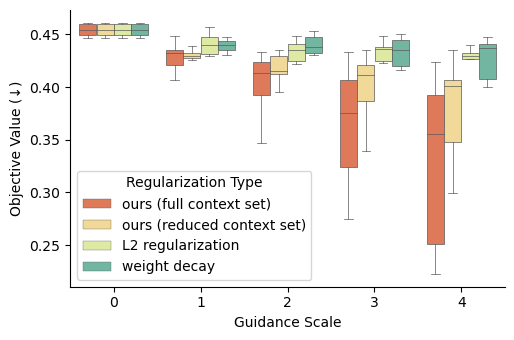

In [14]:
catplot_kws = {"height": 3.5, "aspect":1.5, "kind":"box", "linewidth":0.5, "hue_order": reg_type_map.values(), "palette": "Spectral"}
results["Regularization Type"] = results["reg_type"]

g = sns.catplot(
    data=results, x="scale", y="comp_obj_mean",
    hue="Regularization Type", sharey="row", **catplot_kws,
    showfliers=False,
    legend_out=False,
)

plt.ylabel("Objective Value (↓)")
plt.xlabel("Guidance Scale")

plot_df = results[["split", "reg_type", "scale", "rerun_iteration", "comp_obj_best"]].explode("comp_obj_best", ignore_index=True)
plot_df["comp_obj_best"] = plot_df["comp_obj_best"].astype(float)

plt.savefig("materials.pdf", bbox_inches='tight')

weight decay 4486
ours (full context set) 2944


/tmp/ipykernel_2187605/4073172292.py:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple)


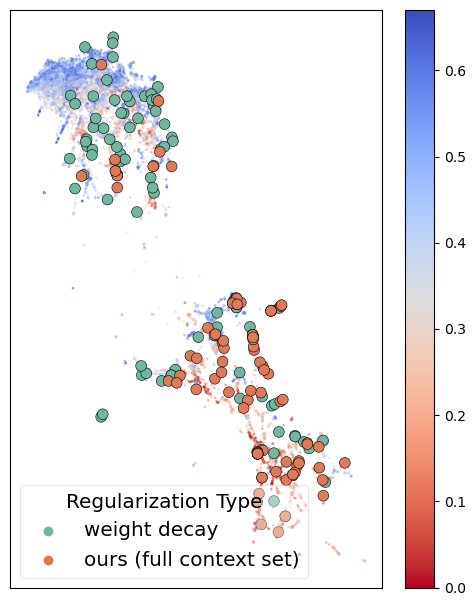

In [15]:
inchi_to_index = pd.Series({m: i for i, m in df["inchi"].items()})

plt_df = []
palette = {
    "weight decay": "#71B6A1",
    "ours (full context set)": "#DE7959",
}

for reg_type in ["weight decay", "ours (full context set)"]:

    samples = results[
        (results["split"]=="cluster_split") & (results["reg_type"]==reg_type) & (results["scale"]==4)
    ]["valid_inchi"].explode()
    samples = samples[samples.isin(inchi_to_index.keys())]
    print(reg_type, len(samples))
    ids = samples.sample(n=100, random_state=0).map(inchi_to_index).values
    embeds = mapper.embedding_[ids]
    plt_df.append(pd.DataFrame({"x1": embeds[:, 0], "x2": embeds[:, 1], "regularizer": reg_type}))
    
plt_df = pd.concat(plt_df, ignore_index=True)

g = umap.plot.points(
    mapper, labels=df["objective"], alpha=0.2, color_key_cmap='coolwarm_r', background='white', 
    subset_points=np.logical_and(mapper.embedding_[:, 0] < 0, mapper.embedding_[:, 1] > 10),
    show_legend=False, height=750, width=600,
)

plt_df = plt_df[(plt_df["x1"] < 0) & (plt_df["x2"] > 10)]
f = sns.scatterplot(data=plt_df, x="x1", y="x2", hue="regularizer", s=60, marker="o", palette=palette, linewidth=0.4, edgecolor="black", legend="full")
g.texts[0].set_visible(False)
g.axes.yaxis.set_label_position("right")

import matplotlib.cm as cm
scalarmappaple = cm.ScalarMappable(cmap=cm.coolwarm_r)
scalarmappaple.set_array(df["objective"])
plt.colorbar(scalarmappaple)

plt.legend(fontsize="x-large", loc="lower left", title="Regularization Type", title_fontsize="x-large", framealpha=0.4) # using a size in points
plt.savefig("materials_umap.pdf", bbox_inches='tight')
plt.savefig("materials_umap.png", dpi=300, bbox_inches='tight')

In [16]:
catplot_kws = {"height": 4, "aspect":1.5, "kind":"box", "linewidth":0.5, "hue_order": reg_type_map.values(), "palette": "Spectral"}
results["Regularization Type"] = results["reg_type"]

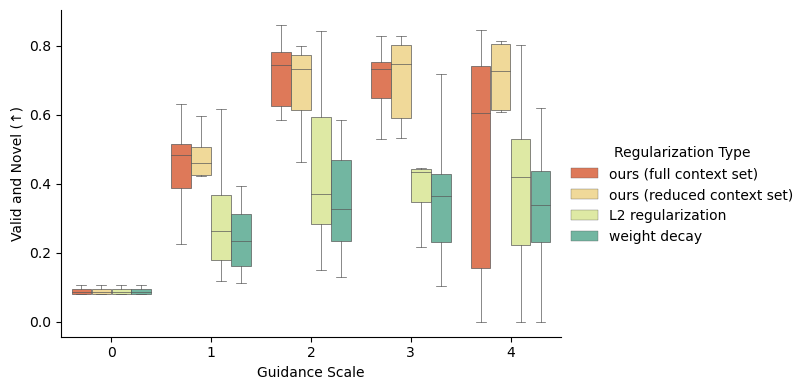

In [17]:
g = sns.catplot(
    data=results, x="scale", y="valid_and_novel",
    hue="Regularization Type", sharey="row", **catplot_kws,
    showfliers=False,
    legend_out=True,
)

plt.ylabel("Valid and Novel (↑)")
plt.xlabel("Guidance Scale")

plot_df = results[["split", "reg_type", "scale", "rerun_iteration", "comp_obj_best"]].explode("comp_obj_best", ignore_index=True)
plot_df["comp_obj_best"] = plot_df["comp_obj_best"].astype(float)

plt.savefig("materials_valid_and_novel.pdf",bbox_inches='tight')

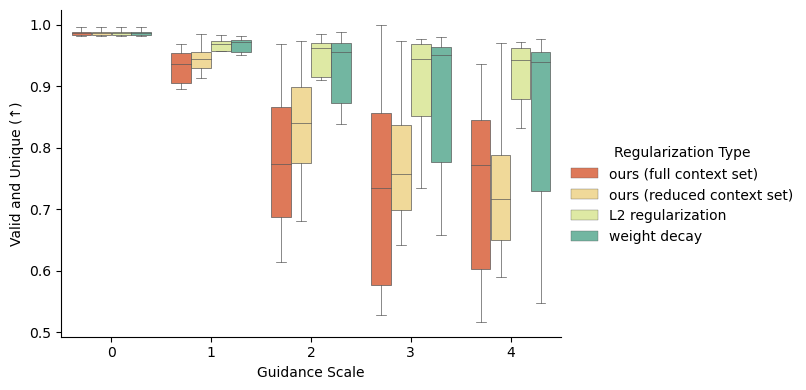

In [18]:
g = sns.catplot(
    data=results, x="scale", y="mol_unique",
    hue="Regularization Type", sharey="row", **catplot_kws,
    showfliers=False,
    legend_out=True,
)

plt.ylabel("Valid and Unique (↑)")
plt.xlabel("Guidance Scale")

plot_df = results[["split", "reg_type", "scale", "rerun_iteration", "comp_obj_best"]].explode("comp_obj_best", ignore_index=True)
plot_df["comp_obj_best"] = plot_df["comp_obj_best"].astype(float)

plt.savefig("materials_unique.pdf",bbox_inches='tight')